# VIIRS Day-Night Band Data - Exploration and Preprocessing
## Download data

In [1]:
!curl https://detecting-poverty.s3.amazonaws.com/lscale/viirs/VNL_v2_npp_2016_global_vcmslcfg_c202102150000.median_masked.tif.gz -o viirs2020.tif.gz
!gzip -d viirs2020.tif.gz
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  264M  100  264M    0     0  76.4M      0  0:00:03  0:00:03 --:--:-- 76.3M
gzip: viirs2020.tif already exists; do you wish to overwrite (y or n)? n
	not overwritten
sample_data  subsahara_shapes.json  viirs2020.tif  viirs2020.tif.gz


In [15]:
!curl https://detecting-poverty.s3.amazonaws.com/lscale/subsahara_shapes.json -o subsahara_shapes.json
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62787  100 62787    0     0   242k      0 --:--:-- --:--:-- --:--:--  241k
sample_data  subsahara_shapes.json  viirs2020.tif


## Install and Load Modules

In [25]:
!pip install rasterio
!pip install boto3
!pip install pyproj

     |████████████████████████████████| 6.6MB 5.1MB/s 


In [18]:
from PIL import Image
import os
import rasterio
import matplotlib.pyplot as plt
import shapely
import json
import pyproj
import boto3
import numpy as np

In [20]:
plt.rcParams["figure.figsize"] = (20,20)

## Read

In [3]:
viirs = rasterio.open('viirs2020.tif')

In [4]:
viirs

<open DatasetReader name='viirs2020.tif' mode='r'>

In [5]:
print(
    "VIIRS Metadata -----\n"
    f"CRS: {str(viirs.crs)}\n",
    f"Bounds: {str(viirs.bounds)}\n",
    f"Shape: {str(viirs.shape)}\n",
    f"Scales: {str(viirs.scales)}"
)


VIIRS Metadata -----
CRS: EPSG:4326
 Bounds: BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335)
 Shape: (33601, 86401)
 Scales: (1.0,)


In [6]:
# !cat subsahara_shapes.json
with open('subsahara_shapes.json', 'r') as f:
    subsahara_bbox = json.load(f)['bbox']
    print(subsahara_bbox)

[[-17.529520034999962, -46.98186735699994], [51.415031396000074, 16.69295721700007]]


## Subsetting VIIRS to Sub-Saharan Africa

In [7]:
(west, south), (east, north) = subsahara_bbox

In [31]:
# utm_prj = pyproj.Proj(viirs.crs)
# lonlat_proj = pyproj.Proj("WGS84")
# pyproj.transform(lonlat_proj, utm_prj, west, south)
# THE SAME...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  This is separate from the ipykernel package so we can avoid doing imports until


(-17.529520034999962, -46.98186735699994)

In [8]:
miny, minx = viirs.index(west, south)
print((minx,miny))

maxy, maxx = viirs.index(east, north)
print((maxx, maxy))

(38993, 29276)
(55540, 13994)


In [9]:
subsahara_window = rasterio.windows.Window(minx, maxy, abs(maxx-minx), abs(maxy-miny))
subsahara_window

Window(col_off=38993, row_off=13994, width=16547, height=15282)

In [10]:
viirs_subsahara = viirs.read(window=subsahara_window)

In [12]:
viirs_subsahara.shape

(1, 15282, 16547)

In [16]:
viirs_subsahara[0,15281,0]

0.0

In [27]:
print(
    f"Max Reflectance: {viirs_subsahara.max()}\n",
    f"Min Reflectance: {viirs_subsahara.min()}\n",
    f"Avg Reflectance: {viirs_subsahara.mean()}"
)

Max Reflectance: 15503.9091796875
 Min Reflectance: -0.11136592924594879
 Avg Reflectance: 0.02252795547246933


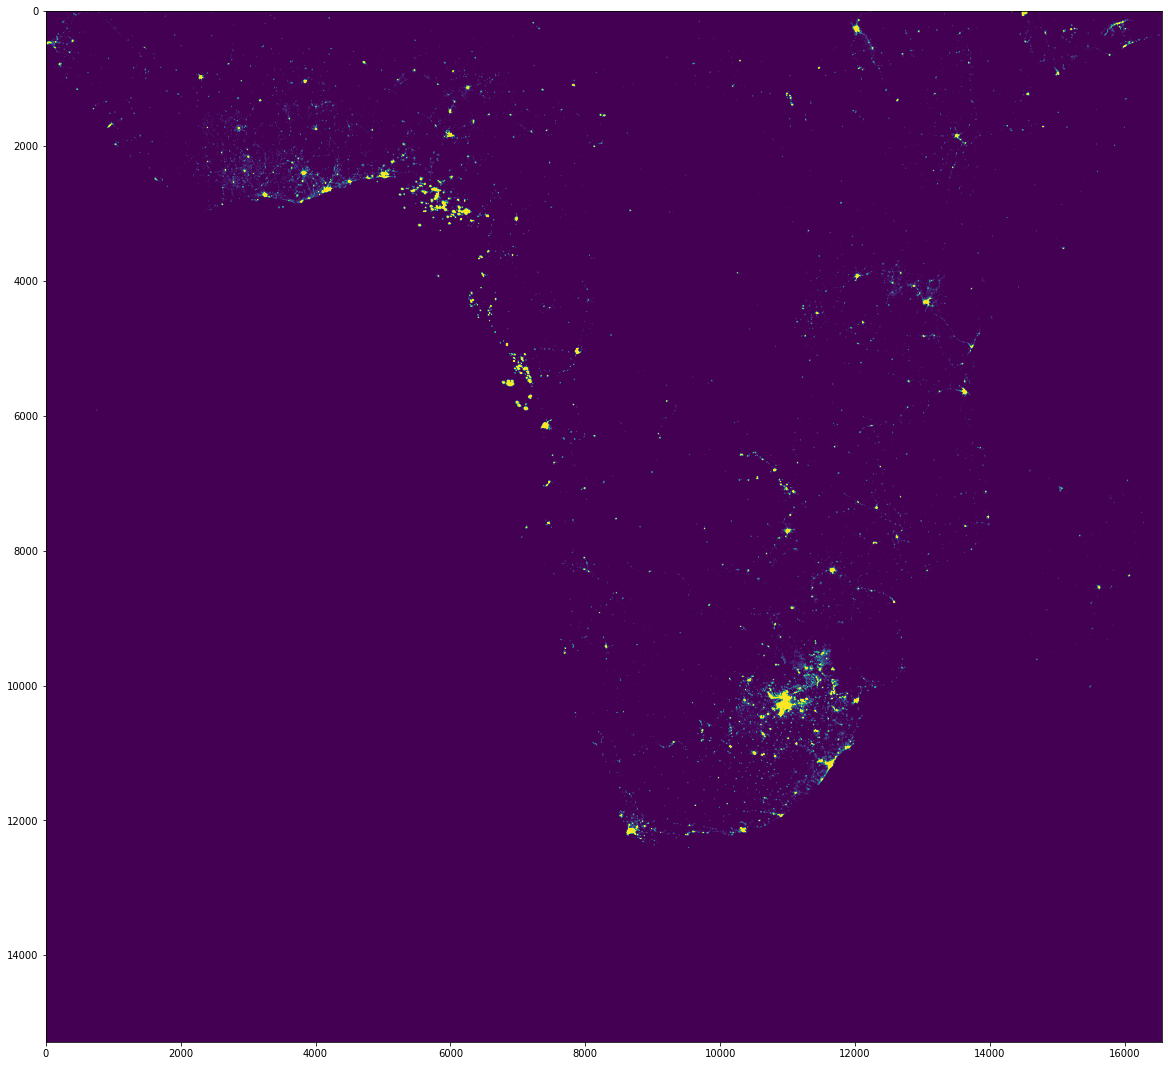

In [25]:
plt.imshow(
    np.log(viirs_subsahara[0,:,:] + 1), # log transform to better see contrast
    vmin=0, vmax=1
)

# PERHAPS MORE VISUAL EXPLORATION HERE WITH BOKEH/DATASHADER ???

## Write Subset to S3 -- Unfinished

In [28]:
viirs.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 86401, 'height': 33601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0041666667, 0.0, -180.00208333335,
       0.0, -0.0041666667, 75.00208333335), 'tiled': False, 'interleave': 'band'}

In [ ]:
# Below Copied from https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html#writing
with rasterio.open(
        'viirs-subsahara.tif', 'w',
        driver='GTiff', width=500, height=300, count=1,
        dtype=image.dtype) as dst:
    dst.write(image, window=Window(50, 30, 250, 150), indexes=1)